In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf 
import tensorflow_datasets as tfds
import os


import sys
sys.path.append('/data/codes/ma-fl-mia/')
from src import utils
from src import models

conf = utils.load_config('/data/codes/ma-fl-mia/env.json', '/data/codes/ma-fl-mia/config.json')

In [2]:
train_ds, test_ds = tfds.load('cifar10', split=['train','test'], as_supervised=True)


In [3]:
x_train, y_train = utils.get_np_from_tfds(train_ds)
x_test, y_test = utils.get_np_from_tfds(test_ds)

In [4]:
print(conf)

{'num_clients': 10, 'paths': {'models': '/data/models/ma-fl-mia/federated/', 'code': '/data/codes/ma-fl-mia/flower_train.py'}, 'seed': 20, 'epochs': 1, 'rounds': 150, 'n_attacker_knowledge': 100, 'n_attack_sample': 5000, 'batch_size': 128, 'learning_rate': 0.001, 'weight_clients': False, 'split_mode': 'homogen', 'dirichlet_alpha': 1.0, 'ma_mode': 'rm-cid', 'unit_size': 64, 'model_mode': 'diao_CNN', 'scale_mode': 0.8, 'val_split': False, 'continue_from': None, 'dp': False, 'dp_clipnorm': 0.5, 'dp_noise': 0.1, 'permutate_cuts': True, 'cut_type': 'secure', 'data_norm': False, 'root_path': '/', 'ray_init_args': {'num_cpus': 6}, 'client_resources': None, 'CUDA_VISIBLE_DEVICES': '0'}


In [5]:
model = models.get_model(32, conf=conf, static_bn=False)

In [6]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=1e-5),
    loss=models.get_loss(),
    metrics=['accuracy']
)

In [7]:
history = model.fit(
    x_train, y_train,
    batch_size=conf['batch_size'],
    epochs=25,
    validation_data=[x_test, y_test],
    verbose=1,
)
import copy
m_prev = copy.deepcopy(model)
history_1 = model.fit(
    x_train, y_train,
    batch_size=conf['batch_size'],
    epochs=1,
    validation_data=[x_test, y_test],
    verbose=1,
)

Epoch 1/25
391/391 [==============================] - 11s 19ms/step - loss: 1.2975 - accuracy: 0.5357 - val_loss: 1.2096 - val_accuracy: 0.5737
Epoch 2/25
391/391 [==============================] - 6s 17ms/step - loss: 0.8801 - accuracy: 0.6890 - val_loss: 0.8444 - val_accuracy: 0.7052
Epoch 3/25
391/391 [==============================] - 7s 17ms/step - loss: 0.7112 - accuracy: 0.7499 - val_loss: 0.7926 - val_accuracy: 0.7298
Epoch 4/25
391/391 [==============================] - 6s 17ms/step - loss: 0.5981 - accuracy: 0.7911 - val_loss: 0.8287 - val_accuracy: 0.7305
Epoch 5/25
391/391 [==============================] - 6s 16ms/step - loss: 0.5089 - accuracy: 0.8210 - val_loss: 0.6945 - val_accuracy: 0.7680
Epoch 6/25
391/391 [==============================] - 6s 16ms/step - loss: 0.4340 - accuracy: 0.8477 - val_loss: 0.6930 - val_accuracy: 0.7702
Epoch 7/25
391/391 [==============================] - 6s 16ms/step - loss: 0.3710 - accuracy: 0.8704 - val_loss: 0.6712 - val_accuracy: 0.784

INFO:tensorflow:Assets written to: ram://741129e4-f334-4818-9e10-56bece5515df/assets


INFO:tensorflow:Assets written to: ram://741129e4-f334-4818-9e10-56bece5515df/assets


391/391 [==============================] - 7s 17ms/step - loss: 7.9437e-04 - accuracy: 1.0000 - val_loss: 1.0323 - val_accuracy: 0.8148


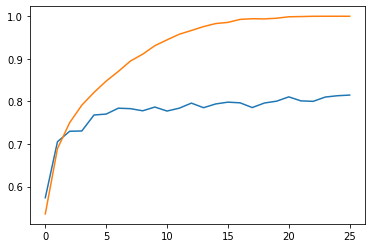

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history['val_accuracy']+history_1.history['val_accuracy'])
plt.plot(history.history['accuracy']+history_1.history['accuracy'])

In [9]:
from src import metrics
conf['model_id']=None
r = metrics.evaluate(conf, model, train_ds, None, test_ds)
r

79/79 [==============================] - 1s 6ms/step - loss: 1.0323 - accuracy: 0.8148


100%|██████████| 10000/10000 [00:22<00:00, 447.47it/s]


{'test_acc': 0.8148000240325928,
 'val_acc': None,
 'train_acc': 1.0,
 'unit_size': 64,
 'alpha': 1.0,
 'model_id': None,
 'params': 392906,
 'model_mode': 'diao_CNN',
 'scale_mode': 0.8,
 'ma_mode': 'rm-cid',
 'adv_std': 29.68,
 'adv_pow': 32.98,
 'adv_cls': 24.22}

In [10]:
last_weights = model.trainable_variables
prev_weights = m_prev.trainable_variables
grad_update = [l-p for l,p in zip(last_weights,prev_weights)]

In [11]:
from tqdm import tqdm_notebook as tqdm

In [12]:
def get_model_grad(model, loss_fn, x, y):
    '''Compute the gradients for this batch'''
    with tf.GradientTape(watch_accessed_variables=True) as tape:
        y_pred = model(x, training=False)
        loss = loss_fn(y, y_pred)
    gradients = tape.gradient(loss, model.trainable_variables)
    return gradients


def csim(a,b):
    return tf.keras.losses.CosineSimilarity(axis=0)(a,b).numpy()

In [13]:
all_cs_train = []
l = 500
for x,y in tqdm(zip(x_train[:l], y_train[:l]), total=l):
    cs_x = []
    grad_xy = get_model_grad(m_prev, models.get_loss(), np.expand_dims(x,0), np.expand_dims(y,0))
    cs = []
    for a,b in zip(grad_update, grad_xy):
        try:
            c = csim(a,b)
            cs.append(c)
        except ValueError as e:
            pass
    all_cs_train.append(np.array(cs))
all_cs_train = np.array(all_cs_train)
np.shape(all_cs_train)

(500, 18)

In [14]:
all_cs_test = []
l = 500
for x,y in tqdm(zip(x_test[:l], y_test[:l]), total=l):
    cs_x = []
    grad_xy = get_model_grad(m_prev, models.get_loss(), np.expand_dims(x,0), np.expand_dims(y,0))
    cs = []
    for a,b in zip(grad_update, grad_xy):
        try:
            c = csim(a,b)
            cs.append(c)
        except ValueError as e:
            pass
    all_cs_test.append(np.array(cs))
all_cs_test = np.array(all_cs_test)
np.shape(all_cs_test)

(500, 18)

[ 1.4927275e-02 -8.9363488e-07  1.4572321e-02  2.4482092e-02
  5.1907339e-04  3.3127173e-05  3.0358687e-02  2.4878310e-02
  7.5126195e-04  3.0283518e-05  4.9859018e-04 -5.4917834e-04
 -6.9406589e-05 -3.9899442e-06  5.6822017e-02  4.0814418e-02
  2.1079505e-02  3.3659361e-02]
[ 4.8781522e-03 -4.1560475e-07  2.0325877e-02  6.5948470e-03
  5.6576054e-04  3.9885224e-05  6.7897066e-03  6.5355333e-03
  6.2096812e-04  3.2234020e-05  3.9781402e-03  7.8390108e-04
  2.5277544e-04  4.2872216e-06  2.7306309e-02  1.4968904e-02
  1.0873655e-02  1.9586522e-03]
17
1


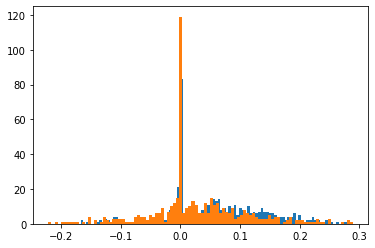

In [15]:
import matplotlib.pyplot as plt

print(np.mean(all_cs_train,0))
print(np.mean(all_cs_test,0))
layer = np.argmax(np.abs(np.mean(all_cs_train,0)-np.mean(all_cs_test,0)))
print(layer)
layer = np.argmin(np.std(all_cs_test,0))
print(layer)
layer = 14
plt.hist(all_cs_train[:,layer], 100)
plt.hist(all_cs_test[:,layer], 100)
plt.show()

In [19]:
layer = 17
fpr = 0.1
# threshold = np.mean([np.mean(all_cs_train,0),np.mean(all_cs_test,0)],0)
# threshold = threshold[layer]
threshold = sorted(all_cs_test[:,layer])[int(fpr*len(all_cs_test))]

tp = len(all_cs_train[all_cs_train[:,layer]<=threshold])
fn = len(all_cs_train[all_cs_train[:,layer]>threshold])
fp = len(all_cs_test[all_cs_test[:,layer]<=threshold])
tn = len(all_cs_test[all_cs_test[:,layer]>threshold])
print(tp, fn, fp, tn)
print((tp+tn)/(tp+tn+fp+fn)*100)

48 452 51 449
49.7


In [20]:
x = x_train[0]
y = y_train[0] 
a = get_model_grad(m_prev, models.get_loss(), np.expand_dims(x,0), np.expand_dims(y,0))
a_ = get_model_grad(m_prev, models.get_loss(), np.expand_dims(x,0), np.expand_dims((y+1)%10,0))
csim(a[14],a_[14])

-0.0038392306

In [21]:
x = x_test[0]
y = y_test[0] 
a = get_model_grad(m_prev, models.get_loss(), np.expand_dims(x,0), np.expand_dims(y,0))
a_ = get_model_grad(m_prev, models.get_loss(), np.expand_dims(x,0), np.expand_dims((y+1)%10,0))
csim(a[14],a_[14])

0.49866602

In [26]:
all_cs_train2 = []
l = 500
for x,y in tqdm(zip(x_train[:l], y_train[:l]), total=l):
    cs_x = []
    grad_right = get_model_grad(m_prev, models.get_loss(), np.expand_dims(x,0), np.expand_dims(y,0))
    grad_wrong = get_model_grad(m_prev, models.get_loss(), np.expand_dims(x,0), np.expand_dims((y+1)%10,0))
    cs = []
    for a,b in zip(grad_right, grad_wrong):
        try:
            c = csim(a,b)
            cs.append(c)
        except ValueError as e:
            pass
    all_cs_train2.append(np.array(cs))
all_cs_train2 = np.array(all_cs_train2)
np.shape(all_cs_train2)

(500, 18)

In [27]:
all_cs_test2 = []
l = 500
for x,y in tqdm(zip(x_test[:l], y_test[:l]), total=l):
    cs_x = []
    grad_right = get_model_grad(m_prev, models.get_loss(), np.expand_dims(x,0), np.expand_dims(y,0))
    grad_wrong = get_model_grad(m_prev, models.get_loss(), np.expand_dims(x,0), np.expand_dims((y+1)%10,0))
    cs = []
    for a,b in zip(grad_right, grad_wrong):
        try:
            c = csim(a,b)
            cs.append(c)
        except ValueError as e:
            pass
    all_cs_test2.append(np.array(cs))
all_cs_test2 = np.array(all_cs_test2)
np.shape(all_cs_test2)

(500, 18)

[ 0.32741857  0.3157648   0.44973153  0.43494165  0.30678457  0.4200656
  0.4491223   0.4458896   0.29295805  0.42654616  0.44485047  0.44179198
  0.2170183   0.43553957  0.44882464  0.43866223 -0.09363756  0.42311913]
[ 0.20525831  0.19828528  0.27701452  0.28098774  0.19143096  0.26504382
  0.28431225  0.28333712  0.18221638  0.26970208  0.27832565  0.27858385
  0.1347889   0.26812905  0.2768153   0.27051273 -0.11756168  0.25933746]
2
16


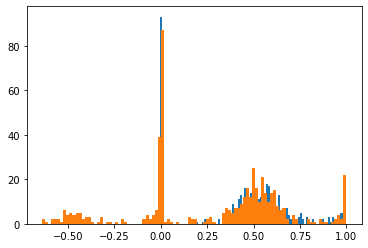

In [28]:
import matplotlib.pyplot as plt

print(np.mean(all_cs_train2,0))
print(np.mean(all_cs_test2,0))
layer = np.argmax(np.abs(np.mean(all_cs_train2,0)-np.mean(all_cs_test2,0)))
print(layer)
layer = np.argmin(np.std(all_cs_test2,0))
print(layer)
layer = 14
plt.hist(all_cs_train2[:,layer], 100)
plt.hist(all_cs_test2[:,layer], 100)
plt.show()

In [29]:
layer = 14
fpr = 0.1
train_mean = np.mean(all_cs_train2,0)
test_mean = np.mean(all_cs_test2,0)
threshold = np.mean([train_mean, test_mean],0)
threshold = threshold[layer]
# threshold = sorted(all_cs_test[:,layer])[int(fpr*len(all_cs_test))]

if train_mean[layer]<test_mean[layer]:
    tp = len(all_cs_train2[all_cs_train2[:,layer]<=threshold])
    fn = len(all_cs_train2[all_cs_train2[:,layer]>threshold])
    fp = len(all_cs_test2[all_cs_test2[:,layer]<=threshold])
    tn = len(all_cs_test2[all_cs_test2[:,layer]>threshold])
else:
    tp = len(all_cs_train2[all_cs_train2[:,layer]>=threshold])
    fn = len(all_cs_train2[all_cs_train2[:,layer]<threshold])
    fp = len(all_cs_test2[all_cs_test2[:,layer]>=threshold])
    tn = len(all_cs_test2[all_cs_test2[:,layer]<threshold])    
print(tp, fn, fp, tn)
print((tp+tn)/(tp+tn+fp+fn)*100)

371 129 267 233
60.4


## Let's make it real

In [22]:
train_attacker = (x_train[-200:-100], y_train[-200:-100])
test_attacker = (x_test[-200:-100], y_test[-200:-100])
attacker_knowledge = {'in_train_data': train_attacker, 'not_train_data':test_attacker}

def attack_obs(model, attacker_knowledge, loss_function):
    train_attacker = attacker_knowledge['in_train_data']
    test_attacker = attacker_knowledge['not_train_data']
    x_train_attacker, y_train_attacker = train_attacker
    x_test_attacker, y_test_attacker = test_attacker
    lbs = len(np.unique(y_train_attacker))
    
    cs_train = []
    for x,y in tqdm(zip(x_train_attacker,y_train_attacker), total=len(y_train_attacker)):
        grad_right = get_model_grad(model, models.get_loss(), np.expand_dims(x,0), np.expand_dims(y,0))
        grad_wrong = get_model_grad(model, models.get_loss(), np.expand_dims(x,0), np.expand_dims((y+1)%lbs,0))
        cs = []
        for a,b in zip(grad_right, grad_wrong):
            try:
                c = csim(a,b)
                cs.append(c)
            except ValueError as e:
                pass
        cs_train.append(np.array(cs))
    cs_train = np.array(cs_train)

    cs_test = []
    for x,y in tqdm(zip(x_test_attacker,y_train_attacker), total=len(y_test_attacker)):
        grad_right = get_model_grad(model, models.get_loss(), np.expand_dims(x,0), np.expand_dims(y,0))
        grad_wrong = get_model_grad(model, models.get_loss(), np.expand_dims(x,0), np.expand_dims((y+1)%lbs,0))
        cs = []
        for a,b in zip(grad_right, grad_wrong):
            try:
                c = csim(a,b)
                cs.append(c)
            except ValueError as e:
                pass
        cs_test.append(np.array(cs))
    cs_test = np.array(cs_test)
    
    train_mean = np.mean(cs_train,0)
    test_mean = np.mean(cs_test,0)
    layer = np.argmax(np.abs(train_mean-test_mean))
    threshold = np.mean([train_mean, test_mean],0)
    sign = train_mean>test_mean
    
    return layer, threshold[layer], sign[layer]

In [32]:
l,t,s = attack_obs(model, attacker_knowledge, models.get_loss())

In [33]:
print(l,t,s)

6 0.043603733 True


In [34]:
layer = l
threshold = t

if not(s):
    tp = len(all_cs_train2[all_cs_train2[:,layer]<=threshold])
    fn = len(all_cs_train2[all_cs_train2[:,layer]>threshold])
    fp = len(all_cs_test2[all_cs_test2[:,layer]<=threshold])
    tn = len(all_cs_test2[all_cs_test2[:,layer]>threshold])
else:
    tp = len(all_cs_train2[all_cs_train2[:,layer]>=threshold])
    fn = len(all_cs_train2[all_cs_train2[:,layer]<threshold])
    fp = len(all_cs_test2[all_cs_test2[:,layer]>=threshold])
    tn = len(all_cs_test2[all_cs_test2[:,layer]<threshold])    
print(tp, fn, fp, tn)
print((tp+tn)/(tp+tn+fp+fn)*100)

383 117 299 201
58.4


## Merlin

In [107]:
def noisy_image(image, noise_std):
    if np.issubdtype(image.dtype, np.integer):
        scale = 255
    else:
        scale = 1.0
     # Generate Gaussian noise with mean 0 and standard deviation 25
    noise = np.random.normal(loc=0, scale=scale*noise_std, size=(32, 32, 3))

    # Add noise to image
    noisy_image = np.clip(image + noise, 0, scale).astype(image.dtype)    
    return noisy_image


def merlin_attack(model, x,y, repeat=50, noise_std=0.09, threshold=0.8):
    count = 0
    l_x = model.evaluate(np.expand_dims(x,0), np.expand_dims(y,0), verbose=0)[0]
    
    x_noised = np.array([noisy_image(x, noise_std) for i in range(repeat)])
    y_noised = np.array([y for i in range(repeat)])
    l_noised = utils.predict_losses(model, x_noised, y_noised, models.get_loss(), verbose=0)
    l_noised = np.array(l_noised)
    count = len(l_noised[l_noised>l_x])
    return (count / repeat)>=threshold

In [113]:
s = []
for i in tqdm(range(0,200)):
    s.append(merlin_attack(model, x_train[i], y_train[i]))
    

In [114]:
tp = len([1 for i in s if i])
fn = len([1 for i in s if not(i)])
print(tp, fn)

167 33


In [115]:
s = []
for i in tqdm(range(0,200)):
    s.append(merlin_attack(model, x_test[i], y_test[i]))

In [116]:
fp = len([1 for i in s if i])
tn = len([1 for i in s if not(i)])
print(fp, tn)

145 55


In [117]:
(tp+tn)/(tp+tn+fp+fn)

0.555

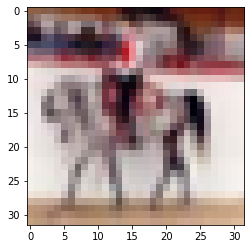

In [81]:
plt.imshow(x_train[0])

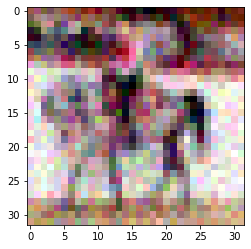

In [118]:
plt.imshow(noisy_image(x_train[0], 0.09))

## Shokri

In [119]:
def get_attack_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    return model


In [148]:
shadow_model_count = 5
x_sm = np.concatenate((train_attacker[0], test_attacker[0]))

x_am = []
y_am = []

for i in range(shadow_model_count):
    sm = models.get_model(32, conf=conf, static_bn=False)
    sm.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=1e-5),
        loss=models.get_loss(),
        metrics=['accuracy']
    )
    hsm = sm.fit(
        train_attacker[0], train_attacker[1],
        epochs=25,
        shuffle=True,
        batch_size=conf['batch_size'],
        verbose=0
    )
    
    sm_losses = sm.predict(x_sm, verbose=0)
    x_asm = sm_losses
    y_asm = np.array(([1] * len(train_attacker[0])) + ([0] * len(test_attacker[0])))
    if i==0:
        x_am = x_asm
        y_am = y_asm
    else:
        x_am = np.concatenate((x_am, x_asm))
        y_am = np.concatenate((y_am, y_asm))

In [122]:
train_preds = model.predict(train_attacker[0])
test_preds = model.predict(test_attacker[0])

x_am2 = np.concatenate((train_preds,test_preds))
y_am2 = np.array(([1] * len(train_attacker[0])) + ([0] * len(test_attacker[0])))

4/4 [==============================] - 0s 4ms/step


In [149]:
y_am

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,

In [150]:
am = get_attack_model()
am.compile(optimizer="adam", loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

h_attack = am.fit(
    x_am, y_am,
    epochs=50,
    shuffle=True,
)

Epoch 1/50
32/32 [==============================] - 1s 3ms/step - loss: 0.7708 - accuracy: 0.5050
Epoch 2/50
32/32 [==============================] - 0s 4ms/step - loss: 0.6421 - accuracy: 0.6500
Epoch 3/50
32/32 [==============================] - 0s 4ms/step - loss: 0.6095 - accuracy: 0.6680
Epoch 4/50
32/32 [==============================] - 0s 4ms/step - loss: 0.5774 - accuracy: 0.6950
Epoch 5/50
32/32 [==============================] - 0s 4ms/step - loss: 0.5466 - accuracy: 0.7240
Epoch 6/50
32/32 [==============================] - 0s 3ms/step - loss: 0.5261 - accuracy: 0.7520
Epoch 7/50
32/32 [==============================] - 0s 3ms/step - loss: 0.5014 - accuracy: 0.7700
Epoch 8/50
32/32 [==============================] - 0s 3ms/step - loss: 0.4746 - accuracy: 0.7780
Epoch 9/50
32/32 [==============================] - 0s 3ms/step - loss: 0.4525 - accuracy: 0.8090
Epoch 10/50
32/32 [==============================] - 0s 3ms/step - loss: 0.4316 - accuracy: 0.8270
Epoch 11/50
32/32 [

In [151]:
fpr_threshold = 0.9

In [152]:
tp = 0
fn = 0
for i in tqdm(range(200)):
    target_pred = model.predict(np.expand_dims(x_train[i],0), verbose=0)
    attack_pred = am.predict(target_pred, verbose=0)
    if attack_pred[0][0]>fpr_threshold:
        tp += 1
    else:
        fn += 1
print(tp, fn)


166 34


In [153]:
fp = 0
tn = 0
for i in tqdm(range(200)):
    target_pred = model.predict(np.expand_dims(x_test[i],0), verbose=0)
    attack_pred = am.predict(target_pred, verbose=0)
    if attack_pred[0][0]>fpr_threshold:
        fp += 1
    else:
        tn += 1
print(fp, tn)


148 52


In [154]:
(tp+tn)/(tp+tn+fp+fn)

0.545